In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Capital de départ
initial_capital = 100_000

# Proportions
portion_buy_and_hold = 2/3
portion_trading = 1/3

# Répartition B&H
ratio_voo = 0.75   # 75% dans VOO
ratio_qqq = 0.25   # 25% dans QQQ

# Watchlist pour la partie court terme
watchlist = ["AAPL", "TSLA", "MSFT", "AMZN", "GOOGL", "META"]  # exemple

start_date = "2020-01-01"
end_date   = "2023-01-01"

# Paramètres de la stratégie court terme
daily_drop_threshold = -0.02   # -2%
stop_loss_pct = 0.01          # 1% stop loss
trailing_stop_pct = 0.01      # 1% trailing stop

In [4]:
df_voo = yf.download("VOO", start=start_date, end=end_date)
df_qqq = yf.download("QQQ", start=start_date, end=end_date)

# Gardons seulement Adj Close pour simplifier
df_voo = df_voo[["Adj Close"]].rename(columns={"Adj Close": "VOO"})
df_qqq = df_qqq[["Adj Close"]].rename(columns={"Adj Close": "QQQ"})

[*********************100%%**********************]  1 of 1 completed

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed


/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [5]:
df_bnh = df_voo.join(df_qqq, how="inner")  # DataFrame Buy & Hold
df_bnh.dropna(inplace=True)  # on enlève les dates incomplètes

In [6]:
data = {}
for ticker in watchlist:
    df_tmp = yf.download(ticker, start=start_date, end=end_date)
    data[ticker] = df_tmp["Adj Close"]

# On construit un DataFrame unique
df_watchlist = pd.DataFrame(data)
df_watchlist.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed


/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%%**********************]  1 of 1 completed


In [7]:
capital_BH = initial_capital * portion_buy_and_hold

first_date = df_bnh.index[0]
price_voo_init = df_bnh.loc[first_date, "VOO"]
price_qqq_init = df_bnh.loc[first_date, "QQQ"]

voo_invest = capital_BH * ratio_voo  # 75% de capital_BH
qqq_invest = capital_BH * ratio_qqq  # 25% de capital_BH

# Nombre de parts achetées (floors pour simplifier)
units_voo = np.floor(voo_invest / price_voo_init)
units_qqq = np.floor(qqq_invest / price_qqq_init)

In [8]:
df_bnh["Value_BH"] = (units_voo * df_bnh["VOO"]) + (units_qqq * df_bnh["QQQ"])

In [9]:
capital_trading = initial_capital * portion_trading

In [10]:
positions = {
    ticker: {
        "is_in": False,
        "entry_price": 0.0,
        "stop_loss": 0.0,
        "trailing_stop": 0.0,
        "shares": 0
    }
    for ticker in watchlist
}

In [11]:
dates = df_watchlist.index
# Pour stocker l'évolution du capital short-term
capital_series = []

for i in range(2, len(dates)):
    today = dates[i]
    yesterday = dates[i-1]
    day_before_yesterday = dates[i-2]

    # ---- 1) On met à jour la valeur de chaque position existante
    # (on regarde le cours de 'yesterday' pour voir si un stop est déclenché)
    for ticker in watchlist:
        if positions[ticker]["is_in"]:
            # prix de clôture
            price_yest = df_watchlist.loc[yesterday, ticker]
            # Mise à jour du trailing stop si on est monté plus haut
            highest_price_since_entry = max(price_yest, positions[ticker]["entry_price"])
            # on suppose un trailing stop = 1% sous le plus haut
            # (Dans la réalité, on le met à jour jour après jour s'il y a un nouveau plus haut)
            new_trailing_stop = highest_price_since_entry * (1 - trailing_stop_pct)
            
            # On garde le max entre le stop_loss fixe et le trailing stop
            positions[ticker]["stop_loss"] = max(
                positions[ticker]["stop_loss"],
                new_trailing_stop
            )
            
            # Vérifier si on est passé sous le stop hier
            if price_yest < positions[ticker]["stop_loss"]:
                # On sort de la position
                # on considère qu'on vend au "stop_loss" (simplification daily)
                exit_price = positions[ticker]["stop_loss"]
                shares = positions[ticker]["shares"]
                capital_trading += exit_price * shares  # On récupère le cash
                # Remettre la structure à zéro
                positions[ticker]["is_in"] = False
                positions[ticker]["entry_price"] = 0.0
                positions[ticker]["stop_loss"] = 0.0
                positions[ticker]["shares"] = 0

    # ---- 2) Repérer les nouveaux signaux d'achat
    # Variation (t-1) vs (t-2)
    # On veut : (Close(yesterday) - Close(day_before_yesterday))/Close(day_before_yesterday) <= -2%
    drop_tickers = []
    for ticker in watchlist:
        ret = (df_watchlist.loc[yesterday, ticker] / df_watchlist.loc[day_before_yesterday, ticker]) - 1
        if ret <= daily_drop_threshold:
            drop_tickers.append(ticker)

    # ---- 3) Exécuter les achats pour les tickers signalés
    # On répartit le capital_trading dispo équitablement
    if len(drop_tickers) > 0:
        alloc_per_ticker = capital_trading / len(drop_tickers)
        for ticker in drop_tickers:
            # N'achetez que si on n'a pas déjà une position ouverte
            if positions[ticker]["is_in"] == False:
                price_to_buy = df_watchlist.loc[yesterday, ticker]  # simplification
                # calcul du nombre d'actions
                shares = np.floor(alloc_per_ticker / price_to_buy)
                if shares > 0:
                    cost = shares * price_to_buy
                    # MàJ capital
                    capital_trading -= cost
                    # MàJ position
                    positions[ticker]["is_in"] = True
                    positions[ticker]["entry_price"] = price_to_buy
                    positions[ticker]["stop_loss"] = price_to_buy * (1 - stop_loss_pct)
                    positions[ticker]["shares"] = shares
                    # On initialise trailing_stop = stop_loss (pour commencer)
                    positions[ticker]["trailing_stop"] = positions[ticker]["stop_loss"]

    # ---- 4) Calculer la valeur latente des positions au jour 'yesterday'
    # (on considère la clôture d'hier comme la valeur du portefeuille à la fin de la journée)
    portfolio_value = capital_trading  # cash non investi
    for ticker in watchlist:
        if positions[ticker]["is_in"]:
            price_yest = df_watchlist.loc[yesterday, ticker]
            shares = positions[ticker]["shares"]
            portfolio_value += price_yest * shares

    # On stocke l'évolution journalière
    capital_series.append((yesterday, portfolio_value))

# Conversion de la liste en DataFrame
df_trading = pd.DataFrame(capital_series, columns=["Date", "Value_Trading"]).set_index("Date")

In [13]:
# Joindre sur l'index de dates
df_total = df_bnh[["Value_BH"]].join(df_trading[["Value_Trading"]], how="outer")

# Interpolation/forward fill si besoin
df_total.ffill(inplace=True)

# Valeur totale du portefeuille
df_total["Total_Portfolio"] = df_total["Value_BH"] + df_total["Value_Trading"]

# On peut calculer les rendements
df_total["Return"] = df_total["Total_Portfolio"].pct_change()
df_total["CumReturn"] = (1 + df_total["Return"]).cumprod() * initial_capital

Valeur finale du portefeuille : 4,063,033.95 $
Performance totale : 3963.03 %
Max Drawdown : -15.05 %
Sharpe ratio approx : 4.93


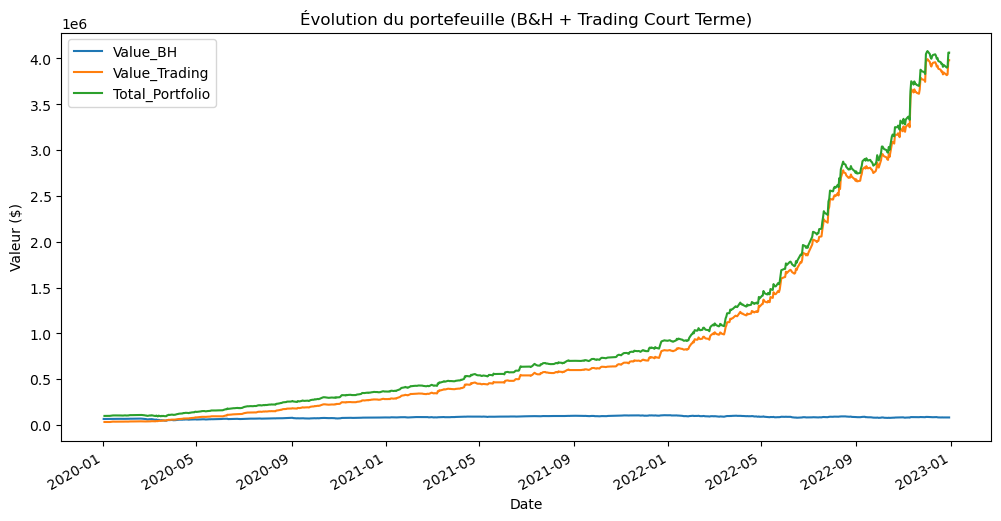

In [14]:
final_value = df_total["Total_Portfolio"].iloc[-1]
total_return_pct = (final_value - initial_capital) / initial_capital * 100

print(f"Valeur finale du portefeuille : {final_value:,.2f} $")
print(f"Performance totale : {total_return_pct:.2f} %")

# Maximum drawdown
df_total["RollMax"] = df_total["Total_Portfolio"].cummax()
df_total["Drawdown"] = (df_total["Total_Portfolio"] - df_total["RollMax"]) / df_total["RollMax"]
mdd = df_total["Drawdown"].min() * 100
print(f"Max Drawdown : {mdd:.2f} %")

# Sharpe ratio (approx, sans taux sans risque, sur base 252 jours)
daily_mean = df_total["Return"].mean()
daily_std  = df_total["Return"].std()
sharpe = (daily_mean / daily_std) * np.sqrt(252)
print(f"Sharpe ratio approx : {sharpe:.2f}")

# Plot
df_total[["Value_BH", "Value_Trading", "Total_Portfolio"]].plot(figsize=(12,6))
plt.title("Évolution du portefeuille (B&H + Trading Court Terme)")
plt.xlabel("Date")
plt.ylabel("Valeur ($)")
plt.show()

In [16]:
df_total

,Value_BH,Value_Trading,Total_Portfolio,Return,CumReturn,RollMax,Drawdown
Date,,,,,,,
2020-01-02,66538.302948,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,66021.505722,3.333333e+04,9.935484e+04,NaN,NaN,9.935484e+04,0.000000
2020-01-06,66313.141479,3.333333e+04,9.964647e+04,0.002935,1.002935e+05,9.964647e+04,0.000000
2020-01-07,66173.511017,3.333333e+04,9.950684e+04,-0.001401,1.001530e+05,9.964647e+04,-0.001401
2020-01-08,66553.867661,3.333333e+04,9.988720e+04,0.003822,1.005358e+05,9.988720e+04,0.000000
...,...,...,...,...,...,...,...
2022-12-23,82719.240143,3.845357e+06,3.928076e+06,0.005239,3.953583e+06,4.079563e+06,-0.037133
2022-12-27,82178.278320,3.816747e+06,3.898925e+06,-0.007421,3.924243e+06,4.079563e+06,-0.044279
2022-12-28,81150.828644,3.826091e+06,3.907242e+06,0.002133,3.932614e+06,4.079563e+06,-0.042240


In [18]:
df_total["Value_Trading"]

Date
2020-01-02             NaN
2020-01-03    3.333333e+04
2020-01-06    3.333333e+04
2020-01-07    3.333333e+04
2020-01-08    3.333333e+04
                  ...     
2022-12-23    3.845357e+06
2022-12-27    3.816747e+06
2022-12-28    3.826091e+06
2022-12-29    3.980492e+06
2022-12-30    3.980492e+06
Name: Value_Trading, Length: 756, dtype: float64